# Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

#  Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
params = dict(
    qntile_B = .1,
    qntile_A = .9,
    n_sets = 4,
    smooth_alpha = .01,
    binary_counts = True
)

# Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy.random import randint
from textman import create_tokens_and_vocab

# Pragmas

In [3]:
%matplotlib inline

# Process

## PREPROCESSING

### Import raw review data

In [4]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


### Clip DOC table by quantile

We only want reviews that are very good or very bad.

In [6]:
bound_A = int(docs.points.quantile(params['qntile_A']))
bound_B = int(docs.points.quantile(params['qntile_B']))
docs = docs[(docs.points <= bound_B) | (docs.points >= bound_A)]

In [7]:
print('A:', bound_A, '\nB:', bound_B)

A: 93 
B: 84


### Convert DOC points feature to A and B labels

In [8]:
docs.loc[docs.points >= bound_A, 'doc_label'] = 'A'
docs.loc[docs.points <= bound_B, 'doc_label'] = 'B'

## TRAINING

### Split out training and test sets from DOCs

We randomly assign each doc a value from 0 to 9, and then select one group for testing, i.e. 10%.

In [9]:
docs['set'] = randint(0,params['n_sets'], len(docs.index))
training_docs = docs.query('set != 0').copy().iloc[:,:-1]
testing_docs = docs.query('set == 0').copy().iloc[:,:-1]

In [10]:
testing_docs.sample(5)

,doc_content,points,doc_label
doc_id,,,
53189,"Lovely, lively and superintense, this is richl...",94,A
62282,"Subtle and shy at first, exhibiting light arom...",93,A
76021,"The tannins dominate this dark, brooding wine....",94,A
74824,"The beauty of this wine is in its elegant, res...",94,A
85168,"This offers intriguing aromas of chopped mint,...",94,A


### Compute Priors

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

We compute the probability of each label in the training corpus. 

Note that since these turn out to be 50/50, we really don't need them in our predictor function.

In [11]:
priors = training_docs['doc_label'].value_counts() / training_docs.shape[0]

In [12]:
priors

A    0.500384
B    0.499616
Name: doc_label, dtype: float64

### Get TOKEN and VOCAB from training corpus

We use our text parsing library tokenize. 

In [13]:
training_tokens, training_vocab = create_tokens_and_vocab(training_docs, src_col='doc_content')

### Compress tokens to binary form

In [14]:
training_tokens = training_tokens.groupby(['doc_id','term_id']).term_str.count().to_frame().rename(columns={'term_str':'n'})

In [15]:
training_tokens.head()

n
doc_id term_id   
336    987      1
       1223     1
       1537     1
       1552     1
       2008     1

### Add sentiment labels to TOKENs

We now transfer the doc label to the tokens, by **transitive inheritance**.

In [16]:
training_tokens = training_tokens.join(training_docs['doc_label'], on='doc_id')

In [17]:
training_tokens.head()

n doc_label
doc_id term_id             
336    987      1         B
       1223     1         B
       1537     1         B
       1552     1         B
       2008     1         B

### Compute Likelihoods 

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+\alpha}{(\sum_{w \in V} count(w,c))+|V|\alpha} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. 

Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [18]:
likelihoods = training_tokens.groupby(['term_id','doc_label']).count().unstack().fillna(0)
likelihoods.columns = likelihoods.columns.droplevel(0)
likelihoods = likelihoods + params['smooth_alpha']
likelihoods = likelihoods / likelihoods.sum()

In [19]:
likelihoods.head()

doc_label,A,B
term_id,,
350,1.111341e-05,6.085502e-08
354,3.692163e-08,1.831736e-05
355,1.480557e-05,6.085502e-08
358,8.495666e-05,6.146357e-06
359,4.065071e-05,6.146357e-06


### Compute logs of likelihoods 

In [20]:
loglhs = log(likelihoods[['A','B']])

### Associate classes with terms

In [21]:
likelihoods['term_str'] = training_vocab['term_str']
likelihoods['class'] = likelihoods[['A','B']].idxmax(1)

In [22]:
likelihoods.head()

doc_label,A,B,term_str,class
term_id,,,,
350,1.111341e-05,6.085502e-08,abbey,A
354,3.692163e-08,1.831736e-05,abbreviated,B
355,1.480557e-05,6.085502e-08,abeja,A
358,8.495666e-05,6.146357e-06,ability,A
359,4.065071e-05,6.146357e-06,able,A


In [23]:
likelihoods['class'].value_counts()

A    4504
B    2794
Name: class, dtype: int64

### Aside: Create Sentiment Lexicon

In [24]:
sentilex = (np.sign(likelihoods['A'] - likelihoods['B'])).to_frame().rename(columns={0:'polarity'})
sentilex['valence'] = (likelihoods['A'] - likelihoods['B']) * 1000
sentilex['term_str'] = training_vocab.term_str
sentilex = sentilex.set_index('term_str')

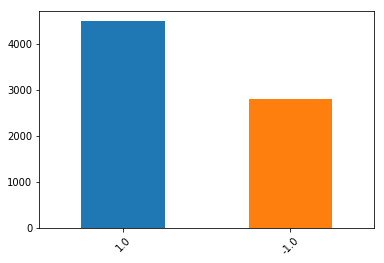

In [25]:
sentilex.polarity.value_counts().plot(kind='bar', rot=45)

In [26]:
sentilex.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,5.954719
rich,1.0,5.742383
drink,1.0,4.722791
years,1.0,4.658099
tannins,1.0,4.329787
ripe,1.0,3.894463
dark,1.0,3.780342
concentrated,1.0,3.660675
vineyard,1.0,3.637150


In [27]:
sentilex.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-18.399592
finish,-1.0,-9.067802
aromas,-1.0,-8.779347
sweet,-1.0,-6.391991
simple,-1.0,-5.986450
soft,-1.0,-5.532388
light,-1.0,-4.832117
green,-1.0,-4.724344
like,-1.0,-3.962109


## TESTING

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$


### Get test corpus

Note that we replace the vocabulary IDs with the old.

In [28]:
testing_tokens, _ = create_tokens_and_vocab(testing_docs, src_col='doc_content')
testing_tokens['term_id'] = testing_tokens.term_str.map(training_vocab.reset_index().set_index('term_str').term_id)
testing_tokens = testing_tokens.dropna()
testing_tokens['term_id'] = testing_tokens['term_id'].astype('int')

In [29]:
testing_tokens.head()

token     term_str  term_id
doc_id sent_id token_id                                   
337    0       1                easy         easy     4610
               3            inviting     inviting     7394
               4           selection    selection    12362
               8         mentholated  mentholated     8783
               9              streak       streak    13440

### Compress tokens to binary form

In [30]:
testing_tokens = testing_tokens.groupby(['doc_id','term_id']).term_str.count().to_frame().rename(columns={'term_str':'n'})

In [31]:
testing_tokens.head()

n
doc_id term_id   
337    1950     1
       2735     1
       3467     1
       3749     1
       4610     1

### Add sentiment models

In [32]:
testing_tokens = testing_tokens.join(loglhs[['A','B']], on='term_id', how='left')

In [33]:
testing_tokens.head()

n          A          B
doc_id term_id                         
337    1950     1 -15.722292 -15.736429
       2735     1  -6.947748  -6.795776
       3467     1  -9.185985 -10.986164
       3749     1  -9.092877  -8.999718
       4610     1 -12.620502  -8.760100

### Compute POSTERIORs and make prediction

In [34]:
testing_docs['A'] = np.exp(testing_tokens.A.unstack().sum(1) + log(priors.A))
testing_docs['B'] = np.exp(testing_tokens.B.unstack().sum(1) + log(priors.B))
testing_docs['prediction'] = testing_docs[['A','B']].idxmax(1)

In [35]:
testing_docs.head(5)

,doc_content,points,doc_label,A,B,prediction
doc_id,,,,,,
337,"An easy and inviting selection, there's a ment...",83,B,2.288756e-92,9.019596e-84,B
341,"Plummy and hinting at black cherry, this wine ...",82,B,3.477688e-63,1.159764e-57,B
343,"Jumpy on the nose at first, but then green tea...",81,B,1.010794e-80,8.839929e-66,B
345,This wine contains some material over 100 year...,100,A,2.392881e-165,3.612005e-191,A
355,A waft of smoky char and toasty oak provide a ...,96,A,4.070407e-160,7.494639e-187,A


## EVALUATION

In [36]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction
T, F = testing_docs.result.value_counts()
grade = round(T/(T+F) * 100)
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

### Grade (Accuracy)

In [37]:
grade

96

In [38]:
CM

doc_label,A,B
prediction,,
A,3029,188
B,41,2798


```bash
AA | 11 | true positive  | TP | "hit," "power"                     
BB | 00 | true negative  | TN | "correct rejection"            
AB | 10 | false positive | FP | "false alarm," "Type I error"  
BA | 01 | false negative | FN | "miss," "Type II error"       
```

In [39]:
def get_results(CM):
    class Results():
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        PPV = TP / (TP + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        BA = (TNR + TPR) / 2
        F1 = (2 *  TP) / (2 * TP + FP + FN)
    return Results()

In [40]:
R = get_results(CM)

In [41]:
assert R.ALL == CM.sum().sum()

In [42]:
R.TP, R.FP, R.TN, R.FN, R.T, R.F, R.ALL

(3029, 188, 2798, 41, 5827, 229, 6056)

### Sensitivity

sensitivity, recall, hit rate, or true positive rate (TPR)

In IR, the probability that a (randomly selected) relevant document is retrieved in a search.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/73004d7856898ebe0bb1d1acd9e87b4be39b91a2)

In [43]:
R.TPR

0.9866449511400651

### Specificity

specificity, selectivity or true negative rate (TNR)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/67c35d27c765b463c514f44b0c654b30f4a1afb0)

In [44]:
R.TNR

0.9370395177494977

### Precision

precision or positive predictive value (PPV)

In IR, the probability that a (randomly selected) retrieved document is relevant.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d854b1544fc77735d575ce0d30e34d7f1eacf707)

In [45]:
R.PPV

0.9415604600559527

### Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/be4377041f6e6226f0235bcc163db409f146090f)

In [46]:
R.ACC

0.9621862615587847

### Balanced Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4383d273906da14c55300ff47ac2e587d56da0cd)

In [47]:
R.BA

0.9618422344447815

### F1 Score

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2c1b789c877bcc32a7a317c723638b14857b7966)

In [48]:
R.F1

0.9635756322570384

### Summary of Performance

In [49]:
T1 = pd.DataFrame([(var, getattr(R, var)) for var in ['T','F','TP','FP','TN','FN','ALL']], columns=['metric','score'])\
    .set_index('metric').T

In [50]:
T2 = pd.DataFrame([(var, round(getattr(R, var),2)) for var in ['TPR','TNR','PPV','ACC','BA','F1']], columns=['metric','score'])\
    .set_index('metric').T

In [51]:
T1

metric,T,F,TP,FP,TN,FN,ALL
score,5827,229,3029,188,2798,41,6056


In [52]:
T2

metric,TPR,TNR,PPV,ACC,BA,F1
score,0.99,0.94,0.94,0.96,0.96,0.96


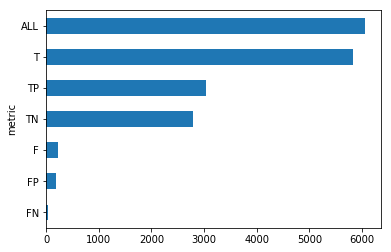

In [53]:
T1.T.sort_values('score').plot.barh(legend=False)

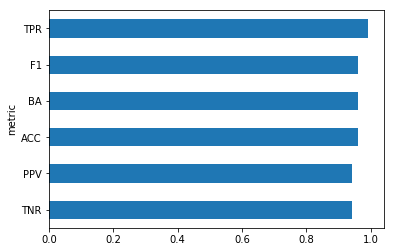

In [54]:
T2.T.sort_values('score').plot.barh(legend=False)

In [69]:
testing_docs.head()

,doc_content,points,doc_label,A,B,prediction,result
doc_id,,,,,,,
337,"An easy and inviting selection, there's a ment...",83,B,2.288756e-92,9.019596e-84,B,True
341,"Plummy and hinting at black cherry, this wine ...",82,B,3.477688e-63,1.159764e-57,B,True
343,"Jumpy on the nose at first, but then green tea...",81,B,1.010794e-80,8.839929e-66,B,True
345,This wine contains some material over 100 year...,100,A,2.392881e-165,3.612005e-191,A,True
355,A waft of smoky char and toasty oak provide a ...,96,A,4.070407e-160,7.494639e-187,A,True
